# Imports

In [1]:
import numpy as np
from PIL import Image
import seaborn as sns
from pathlib import Path

In [2]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
cwd = Path.cwd()
relative_data_path = "image/data"
data_dir = cwd / relative_data_path
data_dir

WindowsPath('d:/Formation/IASchool/DeepLearning/car_detection/image/data')

# Data preparation

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17760 files belonging to 2 classes.
Using 14208 files for training.


In [5]:
validation_df = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17760 files belonging to 2 classes.
Using 3552 files for validation.


In [6]:
val_batches = tf.data.experimental.cardinality(validation_df)
test_dataset = validation_df.take(val_batches // 5)
validation_dataset = validation_df.skip(val_batches // 5)

In [7]:
len(test_dataset.take(1))

1

In [8]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['non-vehicles' 'vehicles']


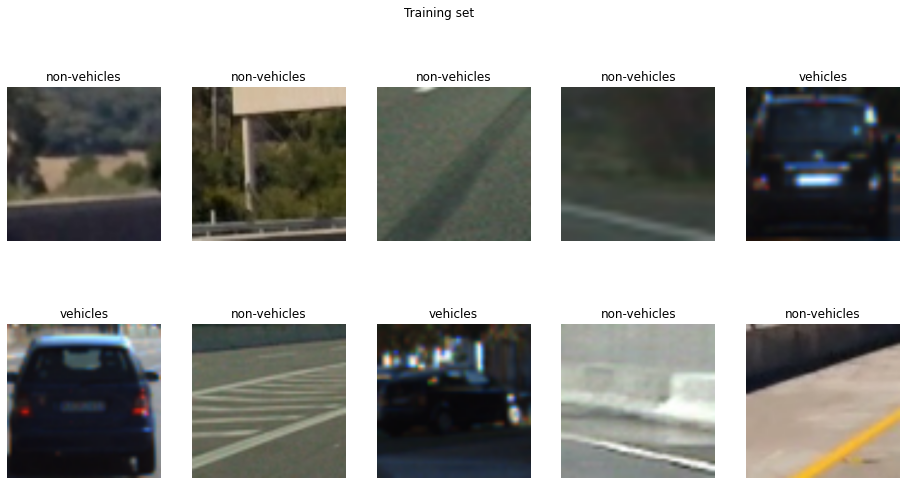

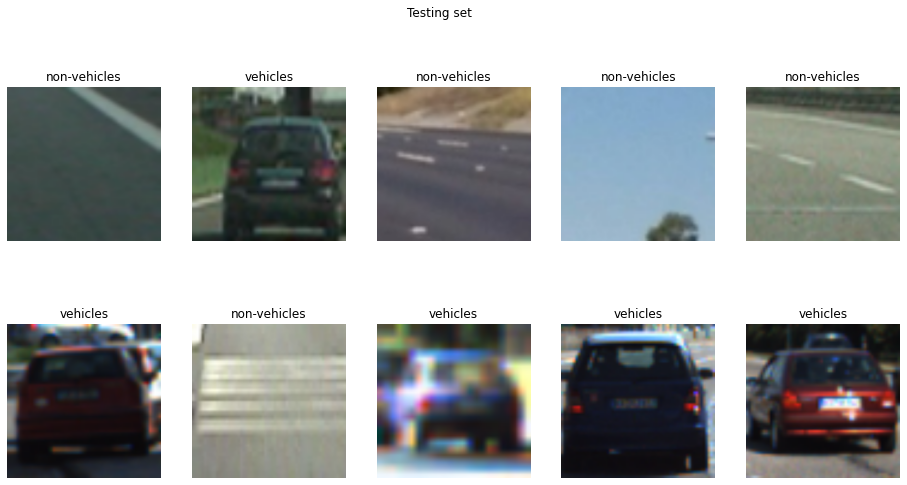

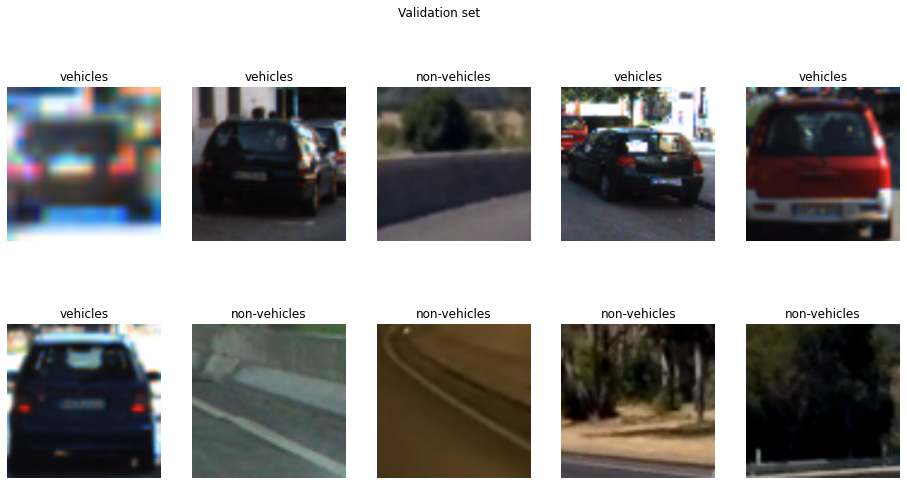

In [9]:
import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):
  plt.figure(figsize=(16, 8))
  plt.suptitle("Training set")
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

for images, labels in test_dataset.take(1):
  plt.figure(figsize=(16, 8))
  plt.suptitle("Testing set")
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

for images, labels in validation_dataset.take(1):
  plt.figure(figsize=(16, 8))
  plt.suptitle("Validation set")
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Import pre trained model

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [12]:
pretrained_model_res = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False, pooling='avg',classes=2)

In [13]:
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

In [14]:
for layer in pretrained_model.layers:
        layer.trainable=False

In [15]:
for layer in pretrained_model_res.layers:
        layer.trainable=False

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

[good doc](https://stackoverflow.com/questions/55929401/how-to-specify-model-compile-for-binary-crossentropy-activation-sigmoid-and-act)

[the meaning of logits](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow)

In [17]:
model = pretrained_model.output
model = global_average_layer(model)
model = tf.keras.layers.Dropout(0.2)(model)
model = Dense(1)(model)
model = tf.keras.Model(inputs = pretrained_model.input , outputs = model)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [19]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [21]:
initial_epochs = 6

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stop])

Epoch 1/6
444/444 [==============================] - 397s 888ms/step - loss: 0.5626 - accuracy: 0.7000 - val_loss: 0.3254 - val_accuracy: 0.8817
Epoch 2/6
444/444 [==============================] - 402s 906ms/step - loss: 0.2879 - accuracy: 0.8896 - val_loss: 0.2303 - val_accuracy: 0.9217
Epoch 3/6
444/444 [==============================] - 382s 860ms/step - loss: 0.2208 - accuracy: 0.9211 - val_loss: 0.1890 - val_accuracy: 0.9371
Epoch 4/6
444/444 [==============================] - 385s 868ms/step - loss: 0.1842 - accuracy: 0.9362 - val_loss: 0.1631 - val_accuracy: 0.9473
Epoch 5/6
444/444 [==============================] - 396s 892ms/step - loss: 0.1659 - accuracy: 0.9406 - val_loss: 0.1493 - val_accuracy: 0.9484
Epoch 6/6
444/444 [==============================] - 403s 907ms/step - loss: 0.1497 - accuracy: 0.9474 - val_loss: 0.1346 - val_accuracy: 0.9533


In [22]:
# model2 = Sequential()
# model2.add(pretrained_model_res)
# # 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model2.add(Dense(1, activation='softmax'))

In [23]:
# model2.summary()

In [24]:
# base_learning_rate = 0.0001
# model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [25]:
# initial_epochs = 6

# history2 = model2.fit(train_dataset,
#                     epochs=initial_epochs,
#                     validation_data=validation_dataset,
#                     callbacks=[early_stop])

# Evaluation

## MobileNet model

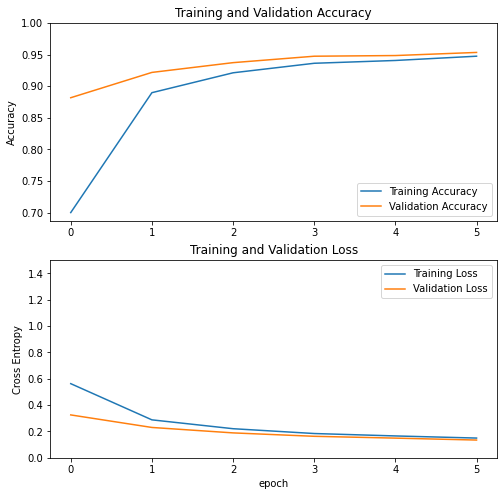

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

In [28]:
predictions

array([-4.2904186,  4.112423 ,  3.0046132,  3.7392287,  3.2740428,
        3.7916958,  3.6022651, -3.6568348, -2.6299999,  3.3597453,
        2.5967767, -6.003193 , -0.8360251, -4.0074687, -1.4069996,
       -2.0841725,  2.3157694, -1.8225331,  1.2364172,  5.120528 ,
        2.8293722,  5.2038636, -1.2261082,  2.863612 , -2.9882324,
        3.8802073,  1.7888886,  4.2192955,  5.4272385, -5.188172 ,
        5.1847773,  4.02685  ], dtype=float32)

In [29]:
predictions = tf.where(predictions < 0, 0, 1)

In [30]:
predictions

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1])>

In [31]:
label_batch

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [32]:
output_class=class_names[np.argmax(predictions[0])]
print("The predicted class is", output_class)

The predicted class is non-vehicles


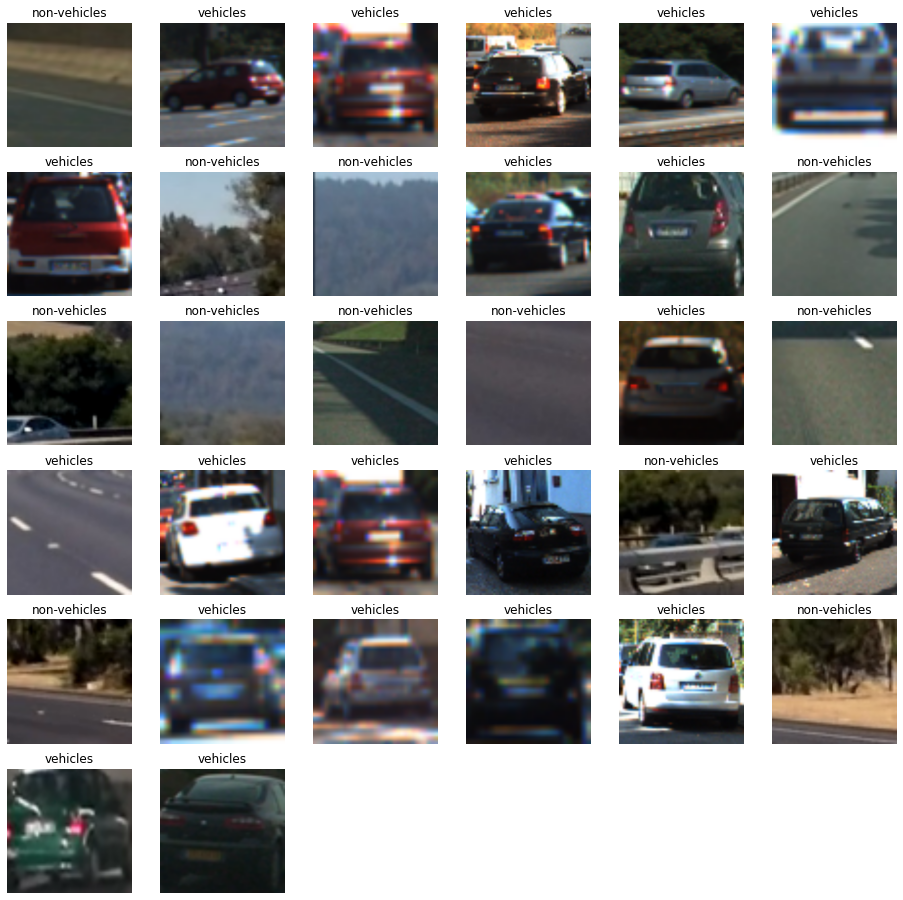

In [33]:
plt.figure(figsize=(16, 16))
for i in range(32):
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [34]:
#Classification report for the first batch

print(classification_report(predictions,label_batch))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.95      0.97        20

    accuracy                           0.97        32
   macro avg       0.96      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



<AxesSubplot:>

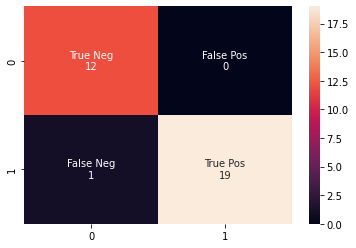

In [35]:
cf_matrix = confusion_matrix(predictions, label_batch)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt="")


In [37]:
all_preds=[]
all_labels=[]
for x in range(len(test_dataset)) : 
    for image_batch, label_batch in test_dataset.as_numpy_iterator():
         pred = model.predict_on_batch(image_batch).flatten()
         preds = tf.where(pred < 0, 0, 1)
         all_preds.extend(preds)
         all_labels.extend(label_batch)

In [38]:
print(classification_report(all_preds,all_labels))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      7505
           1       0.97      0.97      0.97      7983

    accuracy                           0.97     15488
   macro avg       0.97      0.97      0.97     15488
weighted avg       0.97      0.97      0.97     15488



<AxesSubplot:>

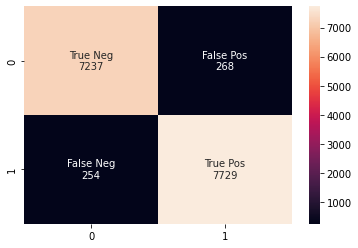

In [39]:
cf_matrix = confusion_matrix(all_preds, all_labels)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt="")


## Resnet model

In [ ]:
# acc = history2.history['accuracy']
# val_acc = history2.history['val_accuracy']

# loss = history2.history['loss']
# val_loss = history2.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.5])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [ ]:
# image_batch2, label_batch2 = test_dataset.as_numpy_iterator().next()
# predictions2 = model2.predict_on_batch(image_batch2).flatten()

In [ ]:
# predictions2 = np.round(predictions2).astype(int)
# predictions2

In [ ]:
# label_batch2

In [ ]:
# plt.figure(figsize=(16, 16))
# for i in range(32):
#   ax = plt.subplot(6, 6, i + 1)
#   plt.imshow(image_batch2[i].astype("uint8"))
#   plt.title(class_names[predictions2[i]])
#   plt.axis("off")

In [ ]:
# #Classification report for the first batch

# print(classification_report(predictions2,label_batch2))

In [ ]:
# cf_matrix = confusion_matrix(predictions2, label_batch2)
# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_names,group_counts)]

# labels = np.asarray(labels).reshape(2,2)

# sns.heatmap(cf_matrix, annot=labels, fmt="")

In [ ]:
# all_preds2=[]
# all_labels2=[]
# for x in range(len(test_dataset)) : 
#     for image_batch, label_batch in test_dataset.as_numpy_iterator().next():
#          pred = model.predict_on_batch(image_batch).flatten()
#          preds = np.round(predictions).astype(int)
#          all_preds2.extend(preds)
#          all_labels2.extend(label_batch)

In [ ]:
# print(classification_report(all_preds2,all_labels2))

In [ ]:
# cf_matrix = confusion_matrix(all_preds2, all_labels2)
# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_names,group_counts)]

# labels = np.asarray(labels).reshape(2,2)

# sns.heatmap(cf_matrix, annot=labels, fmt="")


# save the model

In [40]:
tf.keras.models.save_model(model,'saved_model/tansfer_model_2.h5' )